## Train model for all glaciers, blocking by glacier


In [29]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from matplotlib import pyplot as plt
import xgboost as xgb

from model_functions import select_variables
from model_functions import train_xgb_model
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_fold


In [30]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-06-27_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_all = data[data['balance_netto'].notna()]
glacier_data_all.reset_index(drop=True, inplace=True)


Text(0.5, 0, 'glacier id')

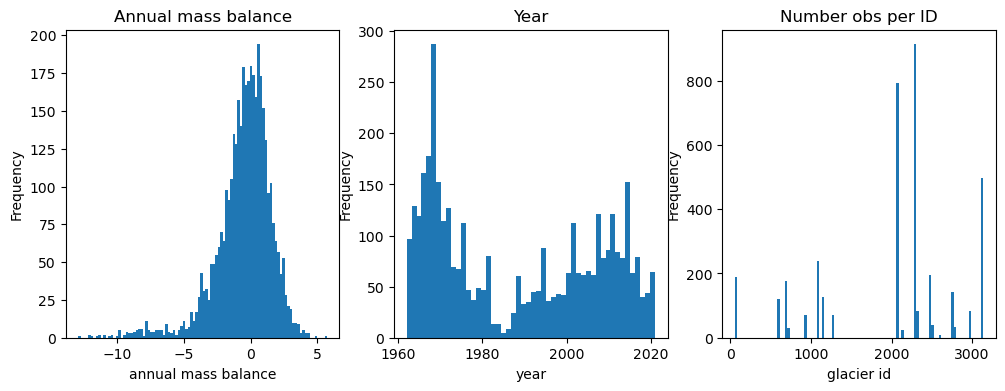

In [31]:
# Plot dataset distributions

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), sharey=False)
glacier_data_all['balance_netto'].plot.hist(bins=100, ax=ax1)
ax1.set_title('Annual mass balance')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('annual mass balance')

glacier_data_all['year'].plot.hist(bins=50, ax=ax2)
ax2.set_title('Year')
ax2.set_xlabel('year')

glacier_data_all['BREID'].plot.hist(bins=100, ax=ax3)
ax3.set_title('Number obs per ID')
ax3.set_xlabel('glacier id')

In [32]:
# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2768, 2478, 2769, 3127, 3141]

df_test = glacier_data_all[glacier_data_all['BREID'].isin(test_glaciers)]
# 54 has 37 points
# 703 has 13 points
# 1280 has 25 points
# 2478 has 22 points
# 2769 has 10 points
# 3127 has 60 points
# test has 323 points in total

df_train = glacier_data_all[~glacier_data_all['BREID'].isin(test_glaciers)]

Train mass balance: mean -0.35130788897005116, min -12.9, max 5.72.
Test mass balance: mean -0.9395476839237057, min -6.3, max 4.1.
Train altitude: mean 1359.92319211103, min 190.0, max 2212.0.
Test altitude: mean 1252.8973660308811, min 390.0, max 2105.0.
Train mean temp: mean -1.7672880851238233, min -7.492487335205055, max 3.914905802408896.
Test mean temp: mean -1.3522719052644447, min -7.176125590006507, max 3.888141886393271.
Train prec sum: mean 0.0673273819015023, min 0.026136178523301197, max 0.132155250757932.
Test prec sum: mean 0.06271467678211604, min 0.026136178523301197, max 0.123711260966956.


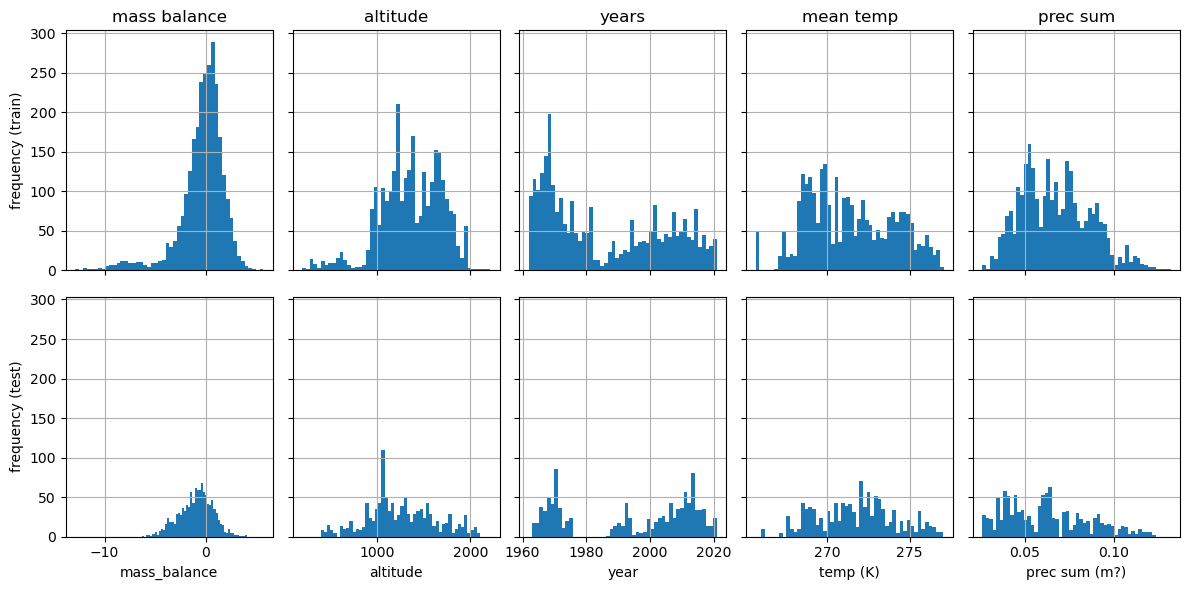

In [33]:
# Number of measurements by topography
temp_cols = ['t2m_oct','t2m_nov','t2m_des','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_des','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']

f, ax = plt.subplots(2, 5, figsize=(12,6), sharey=True, sharex='col')
df_train['balance_netto'].plot.hist(bins=50, ax=ax[0,0])
ax[0,0].set_title('mass balance')
ax[0,0].set_ylabel('frequency (train)')
df_train['altitude'].plot.hist(bins=50, ax=ax[0,1])
ax[0,1].set_title('altitude')
df_train['year'].plot.hist(bins=50, ax=ax[0,2])
ax[0,2].set_title('years')
df_train[temp_cols].mean(axis=1).plot.hist(bins=50, ax=ax[0,3])
ax[0,3].set_title('mean temp')
df_train[prec_cols].sum(axis=1).plot.hist(bins=50, ax=ax[0,4])
ax[0,4].set_title('prec sum')

df_test['balance_netto'].plot.hist(bins=50, ax=ax[1,0])
ax[1,0].set_ylabel('frequency (test)')
ax[1,0].set_xlabel('mass_balance')
df_test['altitude'].plot.hist(bins=50, ax=ax[1,1])
ax[1,1].set_xlabel('altitude')
df_test['year'].plot.hist(bins=50, ax=ax[1,2])
ax[1,2].set_xlabel('year')
df_test[temp_cols].mean(axis=1).plot.hist(bins=50, ax=ax[1,3])
ax[1,3].set_xlabel('temp (K)')
df_test[prec_cols].sum(axis=1).plot.hist(bins=50, ax=ax[1,4])
ax[1,4].set_xlabel('prec sum (m?)')

for row in ax:
    for a in row:
        a.grid()

plt.tight_layout()

T_0 = 273.15
print(f"Train mass balance: mean {df_train['balance_netto'].mean()}, min {df_train['balance_netto'].min()}, max {df_train['balance_netto'].max()}.")
print(f"Test mass balance: mean {df_test['balance_netto'].mean()}, min {df_test['balance_netto'].min()}, max {df_test['balance_netto'].max()}.")
print(f"Train altitude: mean {df_train['altitude'].mean()}, min {df_train['altitude'].min()}, max {df_train['altitude'].max()}.")
print(f"Test altitude: mean {df_test['altitude'].mean()}, min {df_test['altitude'].min()}, max {df_test['altitude'].max()}.")
print(f"Train mean temp: mean {df_train[temp_cols].mean().mean()-T_0}, min {df_train[temp_cols].mean(axis=1).min()-T_0}, max {df_train[temp_cols].mean(axis=1).max()-T_0}.")
print(f"Test mean temp: mean {df_test[temp_cols].mean().mean()-T_0}, min {df_test[temp_cols].mean(axis=1).min()-T_0}, max {df_test[temp_cols].mean(axis=1).max()-T_0}.")
print(f"Train prec sum: mean {df_train[prec_cols].sum(axis=1).mean()}, min {df_train[prec_cols].sum(axis=1).min()}, max {df_train[prec_cols].sum(axis=1).max()}.")
print(f"Test prec sum: mean {df_test[prec_cols].sum(axis=1).mean()}, min {df_test[prec_cols].sum(axis=1).min()}, max {df_test[prec_cols].sum(axis=1).max()}.")

## Training with random 5-fold cv for comparison (all climate variables)

In [ ]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_des','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_des','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_des','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation] for y in x]

df_train_X = df_train.drop(drop_cols, axis=1)
df_train_y = df_train[['balance_netto']]

X_train, y_train = df_train_X.values, df_train_y.values


# Training with only temperature, precipitation and topographical features

### Select features and prepare data for training

In [66]:
# Select features
base_cols = ['altitude','aspect','slope','altitude_climate']
temp_cols = ['t2m_oct','t2m_nov','t2m_des','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_des','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

In [36]:
# Shuffle training dataset in order to shuffle glaciers such that they do not appear in order of glacier ID
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [37]:
# Select features for training
df_train_X_s = select_variables(df_train_s, base_cols, temp_cols, prec_cols)

# Select labels for training
df_train_y_s = select_variables(df_train_s, label_cols)

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [43]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)
print(gp_s)
print(gp_s.shape)
print(X_train_s.shape)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

[2078 3128 2297 ... 2297 2297 2474]
(2738,)
(2738, 28)


In [56]:
df_train_X_s

,altitude,aspect,slope,altitude_climate,t2m_oct,t2m_nov,t2m_des,t2m_jan,t2m_feb,t2m_mar,...,tp_des,tp_jan,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep
0,1093.0,0.025703,0.218802,634.596017,276.772308,268.635864,266.800262,265.028442,264.453766,268.370178,...,0.005322,0.002571,0.003198,0.006457,0.002397,0.003899,0.002854,0.009073,0.004006,0.008548
1,1420.0,5.757709,0.134602,994.833212,275.531128,268.371674,267.200317,267.892670,270.101013,267.242828,...,0.007984,0.014162,0.014243,0.006454,0.004222,0.001101,0.007307,0.005601,0.005114,0.004640
2,1958.0,2.823014,0.033728,1362.652086,272.246338,265.313110,264.371765,264.339905,266.489777,263.639954,...,0.006189,0.009349,0.010368,0.004455,0.002481,0.002027,0.005820,0.004181,0.004437,0.003276
3,1611.0,0.159165,0.088595,1382.210502,269.625793,263.006836,264.121277,263.772827,264.440857,262.922577,...,0.005796,0.006443,0.006475,0.004463,0.004315,0.004096,0.003130,0.003811,0.004685,0.006116
4,572.0,3.617141,0.252619,1322.716089,269.352478,265.884735,262.910431,263.903381,263.422089,266.229401,...,0.005357,0.006581,0.003753,0.004552,0.002179,0.004968,0.003653,0.005674,0.007570,0.009728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,1202.0,0.515098,0.163740,653.949191,275.409668,269.358551,266.657532,266.442719,269.763947,271.292847,...,0.008924,0.004461,0.008222,0.016302,0.006205,0.003339,0.007164,0.008963,0.006549,0.003427
2734,1753.0,4.003039,0.046233,1382.210502,273.230164,267.067474,268.256287,264.092407,260.872131,267.743866,...,0.012523,0.011983,0.003909,0.007382,0.004916,0.005679,0.003005,0.007557,0.006506,0.009774
2735,1686.0,3.206302,0.167392,1322.716089,272.650177,266.070740,259.637024,262.129272,262.061707,258.773132,...,0.003817,0.008573,0.008103,0.001171,0.001844,0.001825,0.004144,0.001378,0.005737,0.005100
2736,1958.0,2.823014,0.033728,1362.652086,269.859589,269.265198,260.739288,265.124847,263.370483,265.162048,...,0.006149,0.013834,0.011705,0.006717,0.004051,0.003380,0.009058,0.003413,0.005482,0.005201


In [57]:
X_train_s[:,0]

array([1093., 1420., 1958., ..., 1686., 1958., 1403.])

### Exploring folds

In [48]:
# View order of sorted glaciers.
df_gp_s = pd.DataFrame(gp_s)
df_gp_s[0].unique()

array([2078, 3128, 2297, 1144, 2474, 1094, 3129,  675, 2514, 3137, 3126,
        596, 3133, 2968, 2772, 2743, 1092, 2148, 3138, 2597], dtype=int64)

In [50]:
# X_train_s.shape is 2738
# gp_s.shape is 2738
# splits_s 0 is 1825 train, 913 validation (Nigardsbreen as validation)
# splits_s 1 is 2108 train, 630 validation (Ålfotbreen as validation)
# splits_s 2 is 2337 train, 401 validation
# splits_s 3 is 2343 train, 395 validation
# splits_s 4 is 2339 train, 399 validation
# Sum of validation obs: 913+630+401+395+399=2738

print('Train, fold 1: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 5: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 5: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 1:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3128 3129 3133 3137 3138]
Validation, fold 1:  [2297]
Train, fold 2:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3128 3129 3133 3137 3138]
Validation, fold 2:  [2078]
Train, fold 3:  [ 596  675 1144 2078 2148 2297 2474 2514 2597 2743 3126 3128 3129 3137]
Validation, fold 3:  [1092 1094 2772 2968 3133 3138]
Train, fold 4:  [ 596 1092 1094 1144 2078 2148 2297 2514 2772 2968 3126 3128 3133 3138]
Validation, fold 4:  [ 675 2474 2597 2743 3129 3137]
Train, fold 5:  [ 675 1092 1094 2078 2297 2474 2597 2743 2772 2968 3129 3133 3137 3138]
Validation, fold 5:  [ 596 1144 2148 2514 3126 3128]


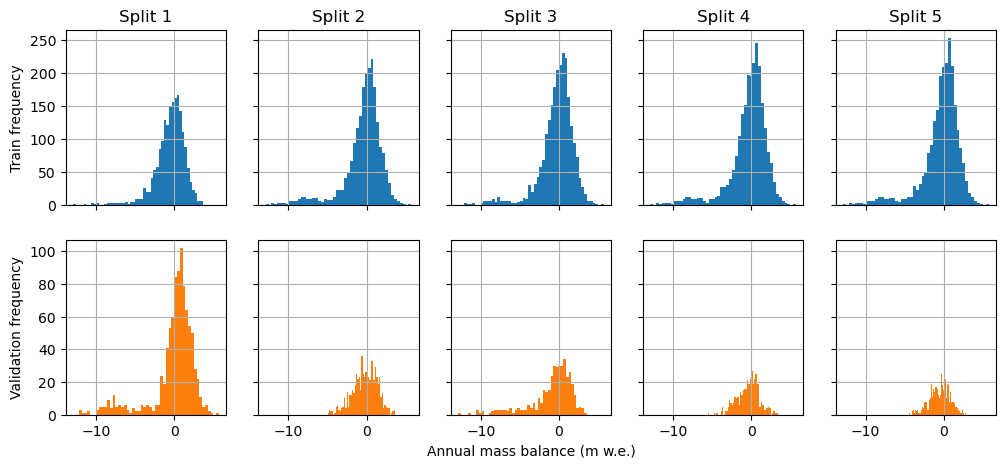

In [51]:
# Plot mass balance distributions of training and validation sets.
j=0
f, ax = plt.subplots(2, len(splits_s), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits_s)):
    if i>2:
        j=1
    df_train_s.iloc[splits_s[i][0]].balance_netto.plot.hist(bins=50, ax=ax[0,i], color='C0')
    df_train_s.iloc[splits_s[i][1]].balance_netto.plot.hist(bins=50, ax=ax[1,i], color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Validation frequency')
ax[1,2].set_xlabel('Annual mass balance (m w.e.)')
    
for row in ax:
    for a in row:
        a.grid()

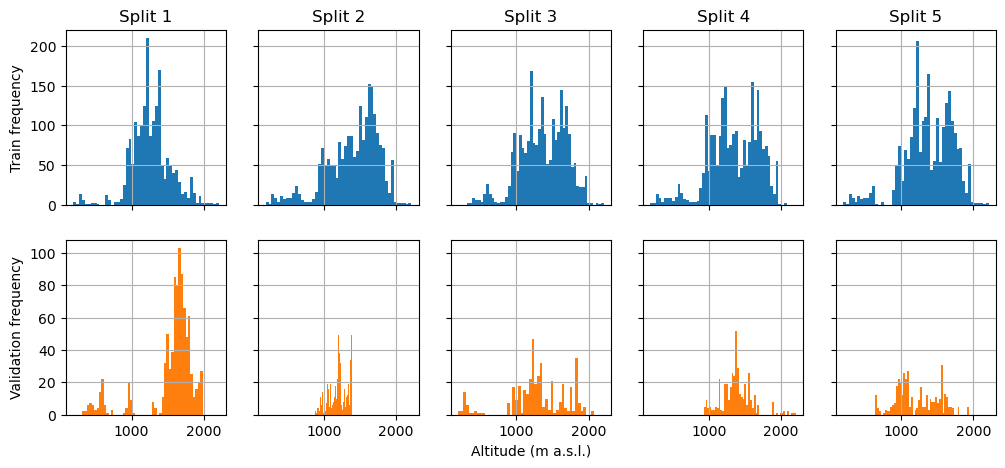

In [52]:
# Plot altitude distributions of training and validation sets.

j=0
f, ax = plt.subplots(2, len(splits_s), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits_s)):
    if i>2:
        j=1
    df_train_s.iloc[splits_s[i][0]].altitude.plot.hist(bins=50, ax=ax[0,i], color='C0')
    df_train_s.iloc[splits_s[i][1]].altitude.plot.hist(bins=50, ax=ax[1,i], color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Validation frequency')
ax[1,2].set_xlabel('Altitude (m a.s.l.)')
    
for row in ax:
    for a in row:
        a.grid()

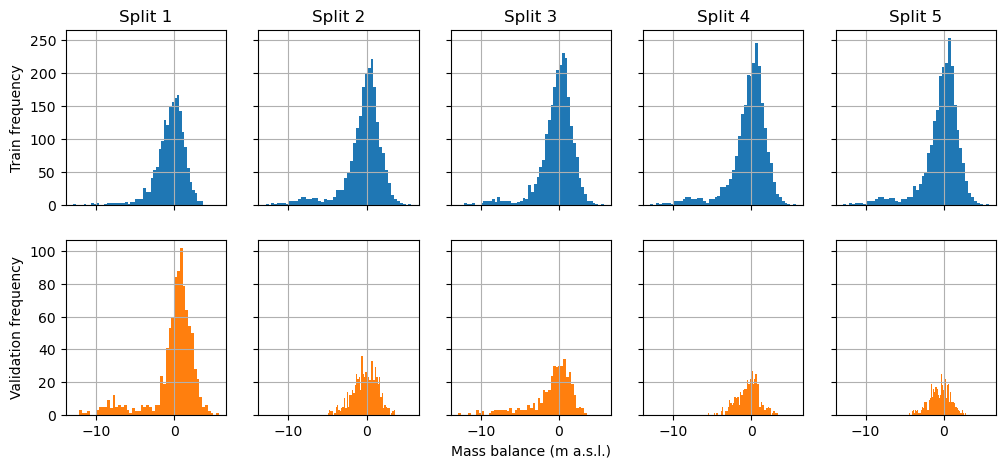

In [74]:
# CHECK THAT SPLITS ARE PERFORMED CORRECTLY

j=0
f, ax = plt.subplots(2, len(splits_s), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits_s)):
    if i>2:
        j=1
    ax[0,i].hist(X_train_s[splits_s[i][0],0], bins=50, color='C0')
    ax[1,i].hist(X_train_s[splits_s[i][1],0], bins=50, color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Validation frequency')
ax[1,2].set_xlabel('Altitude (m a.s.l.)')
    
for row in ax:
    for a in row:
        a.grid()

### Train model

In [62]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -1.712346463319846
Grid search best hyperparameters:  {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}
Cross validation scores per fold:  [-1.04266768 -2.18351812 -2.07217911 -0.75626956 -2.50709785]
Mean cross validation score:  -1.712346463319846
Standard deviation:  0.6849328059931279


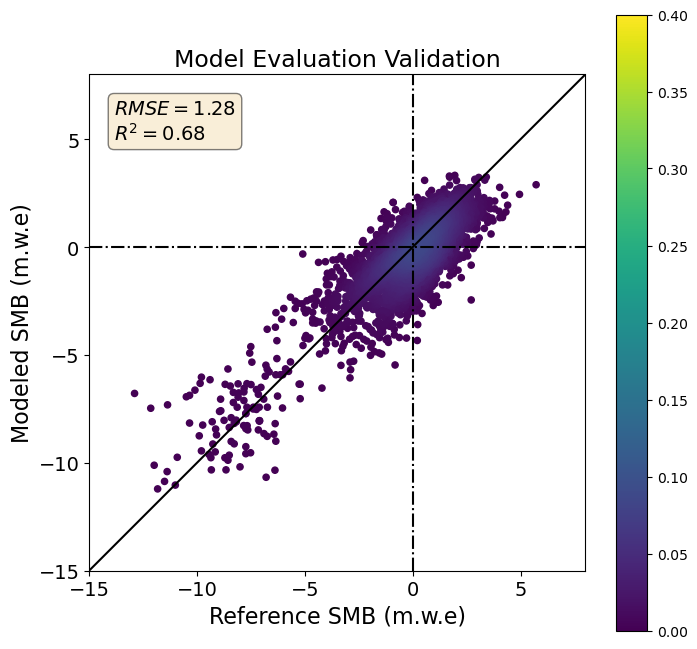

In [63]:
# Train model
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, scorer='neg_mean_squared_error')

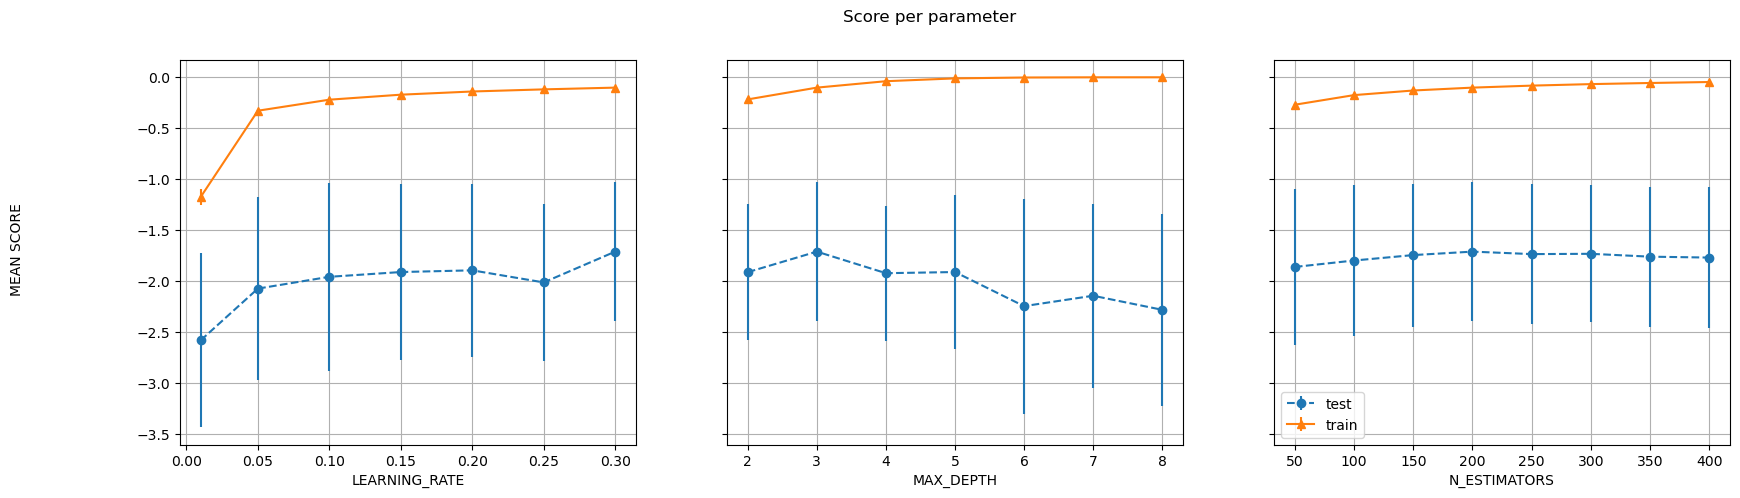

In [64]:
plot_gsearch_results(cv_grid)

In [65]:
# Save model
##import joblib

# Save cv-object
##joblib.dump(cv_grid, 'Models/cv_block_glacier_5fold_temp_prec.pkl')
## joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

# Training with all climate variables

### Select features and prepare data for training

In [79]:
# Select features to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_des','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_des','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_des','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation] for y in x]

In [80]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [81]:
# Select features for training
df_train_X_s = df_train_s.drop(drop_cols, axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance_netto']]

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [82]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

### Check previous mistake

In [71]:
df_train_X_test = df_train.drop(drop_cols, axis=1)
df_train_y_test = df_train[['balance_netto']]
X_train_test, y_train_test = df_train_X_test.values, df_train_y_test.values
splits_test = list(group_kf.split(X_train_test, y_train_test, gp_s))

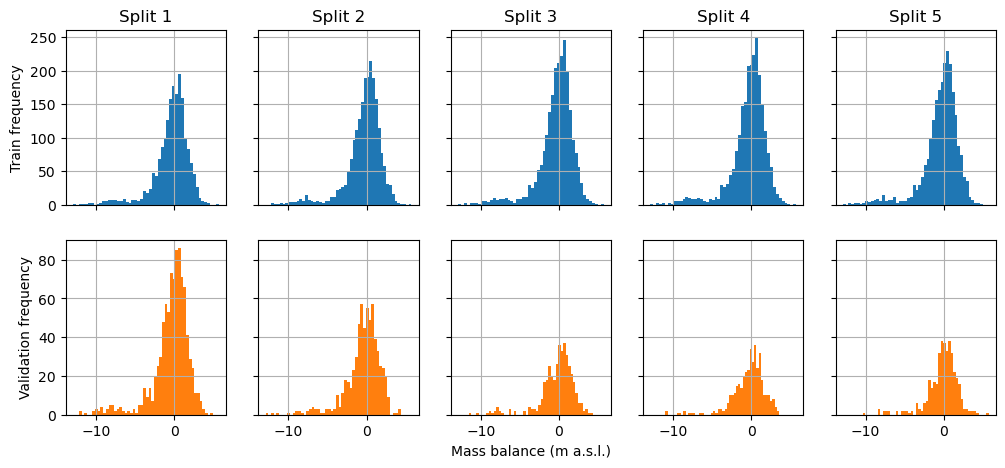

In [75]:
# CHECK THAT SPLITS ARE PERFORMED CORRECTLY

j=0
f, ax = plt.subplots(2, len(splits_test), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits_test)):
    if i>2:
        j=1
    ax[0,i].hist(y_train_test[splits_test[i][0],0], bins=50, color='C0')
    ax[1,i].hist(y_train_test[splits_test[i][1],0], bins=50, color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Validation frequency')
ax[1,2].set_xlabel('Mass balance (m a.s.l.)')
    
for row in ax:
    for a in row:
        a.grid()

### Train model

In [83]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -1.9558088520586168
Grid search best hyperparameters:  {'learning_rate': 0.25, 'max_depth': 3, 'n_estimators': 300}
Cross validation scores per fold:  [-1.2744684  -3.36007438 -2.38117763 -0.74539482 -2.01792903]
Mean cross validation score:  -1.9558088520586168
Standard deviation:  0.9040006772454033


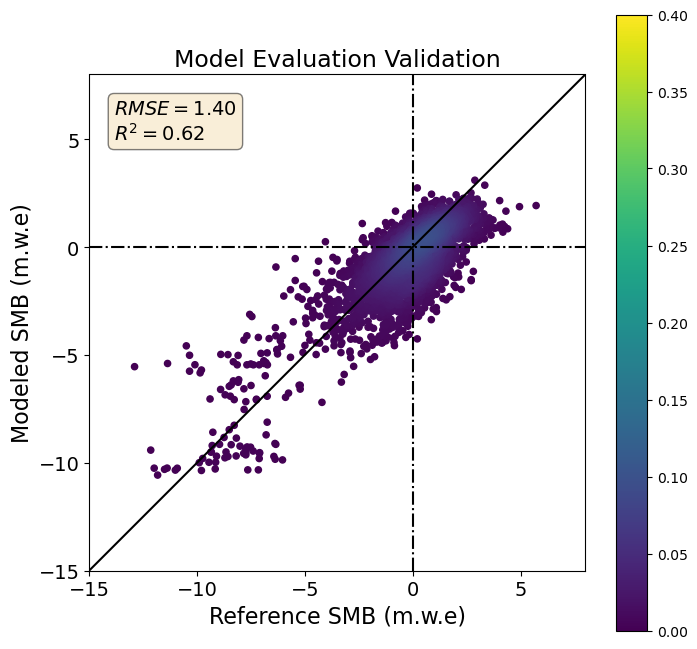

In [84]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

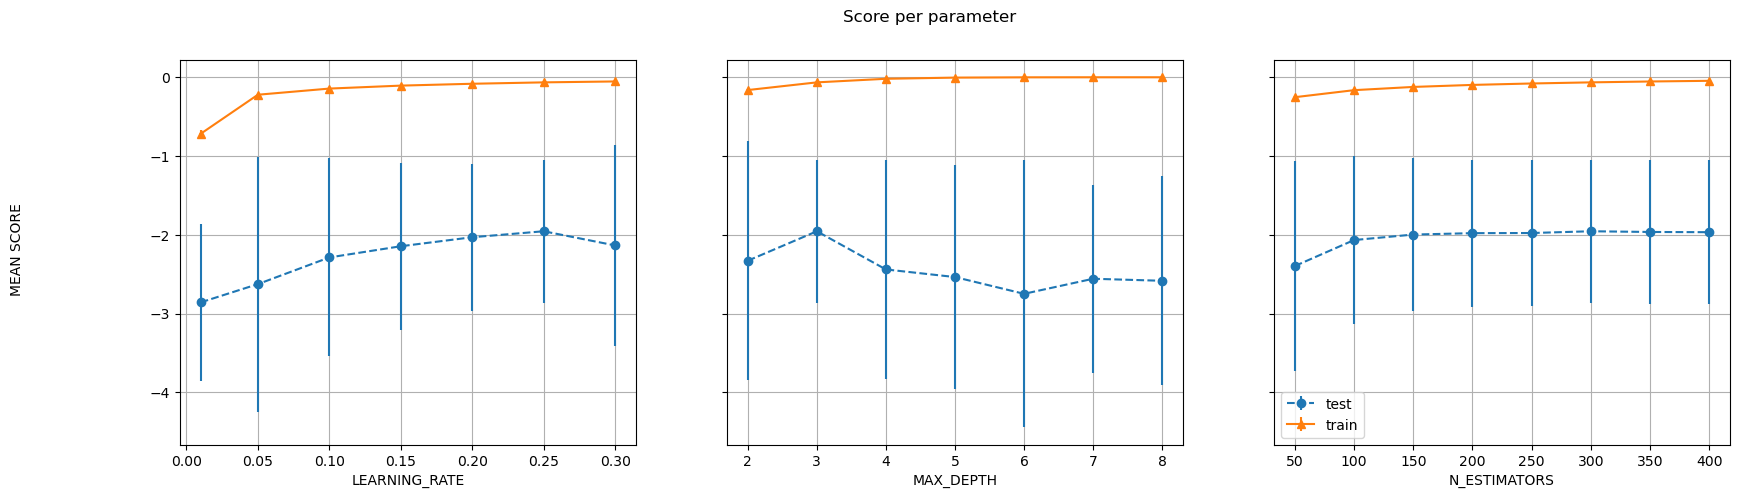

In [85]:
plot_gsearch_results(cv_grid)

In [86]:
# Save model

##import joblib

# Save cv-object
##joblib.dump(cv_grid, 'Models/cv_block_glacier_5fold_all_climate_correct.pkl')
## joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_block_glacier_5fold_all_climate_correct.pkl']

In [18]:
#test = joblib.load('Models/cv_block_glacier_5fold_all_climate.pkl')
# fitted_model = xgb.XGBRegressor(learning_rate = test.best_params_['learning_rate'], 
#                                 n_estimators = test.best_params_['n_estimators'],
#                                 max_depth = test.best_params_['max_depth'])

In [87]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X_s.columns)[ind]

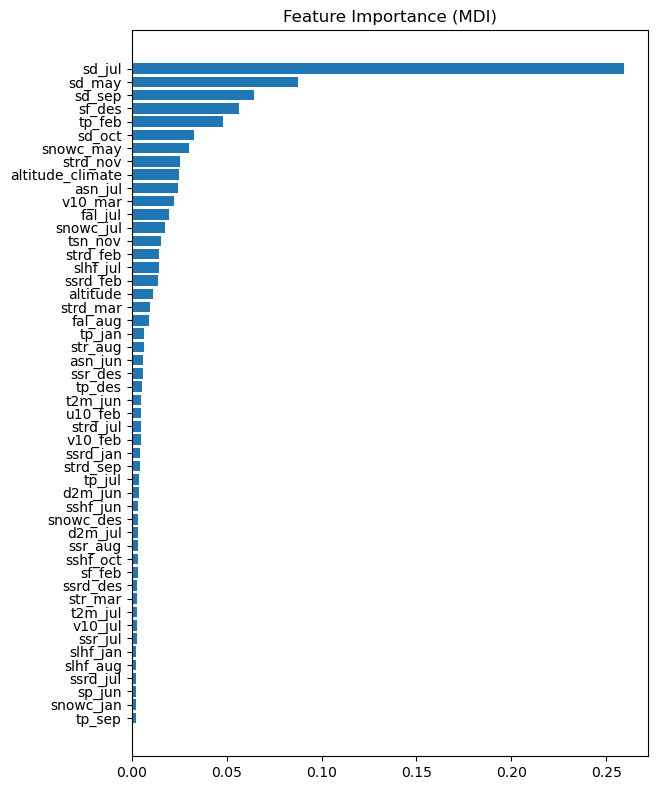

In [88]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Train model with fewer (50) trees

In [19]:
# Performance with fewer trees
#best_model_few_trees = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, scorer='neg_mean_squared_error')

In [26]:
model_fewer_trees = xgb.XGBRegressor(learning_rate = cv_grid.best_params_['learning_rate'], 
                                     n_estimators = 50,
                                     max_depth = cv_grid.best_params_['max_depth'])

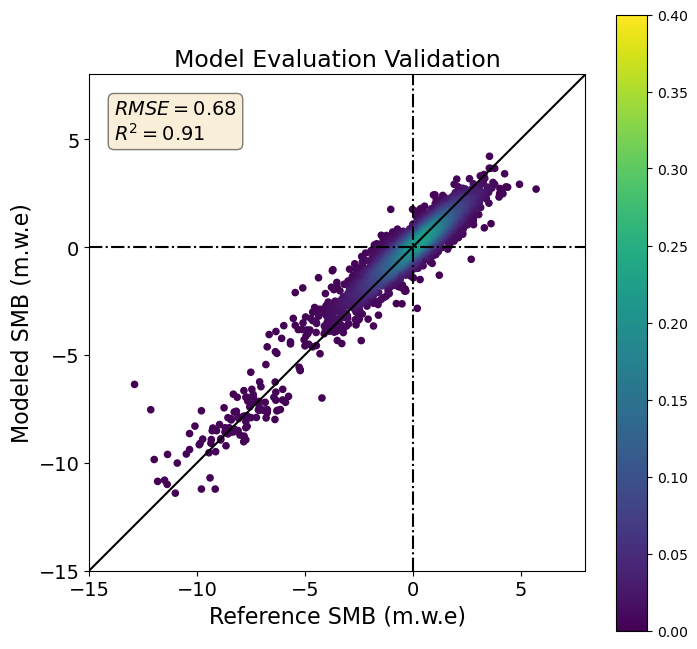

In [27]:
plot_prediction_per_fold(X_train_s, y_train_s, model_fewer_trees, splits_s)


## Train model without topographical features

In [21]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [22]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_des','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_des','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_des','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
topo = ['altitude', 'slope', 'aspect', 'altitude_climate']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, topo] for y in x]

df_train_X_s = df_train.drop(drop_cols, axis=1)
df_train_y_s = df_train[['balance_netto']]

In [23]:
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get shuffled glacier ids
gp_s = np.array(df_train_s['BREID'].values)

In [24]:
# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split dataset into groups based on shuffled glacier ids.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [11]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -1.13134422606594
Grid search best hyperparameters:  {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 250}
Cross validation scores per fold:  [-1.50311089 -1.34360427 -1.04190118 -0.82894453 -0.93916026]
Mean cross validation score:  -1.13134422606594
Standard deviation:  0.25284188474930086


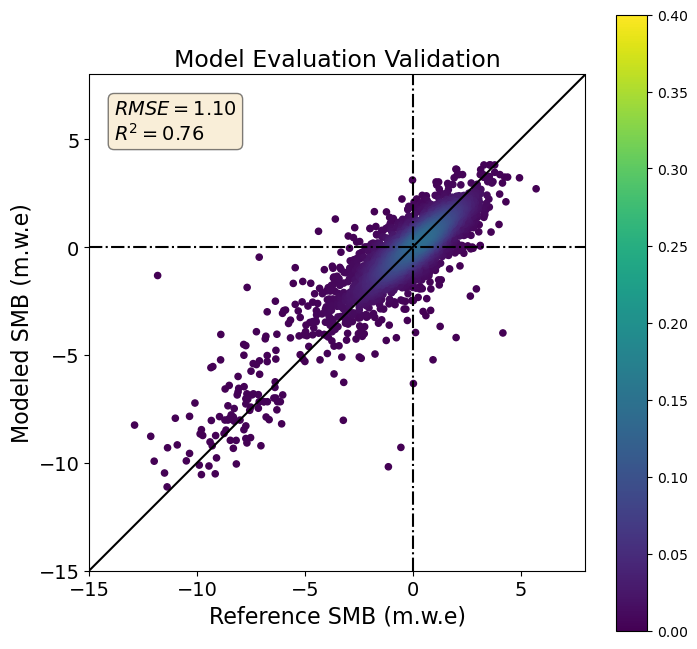

In [12]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [25]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X_s.columns)[ind]

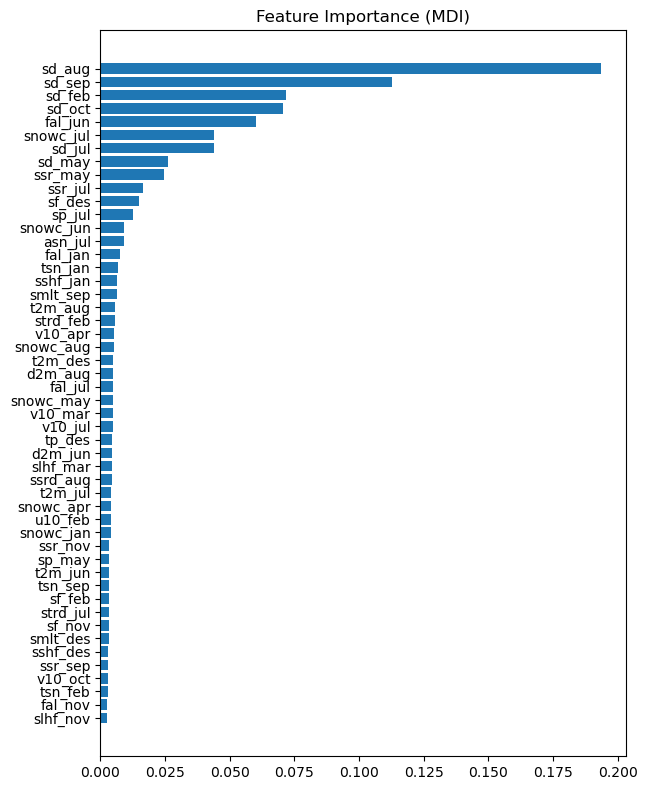

In [26]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Train model without derived climate variables

In [27]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [28]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_des','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_des','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_des','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_des','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_des','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_des','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_des','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_des','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_des','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo] for y in x]

df_train_X_s = df_train.drop(drop_cols, axis=1)
df_train_y_s = df_train[['balance_netto']]

In [29]:
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get shuffled glacier ids
gp_s = np.array(df_train_s['BREID'].values)

In [30]:
# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split dataset into groups based on shuffled glacier ids.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [31]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -0.3671457047357688
Grid search best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 400}
Cross validation scores per fold:  [-0.38897051 -0.45710156 -0.29366547 -0.32445579 -0.3715352 ]
Mean cross validation score:  -0.3671457047357688
Standard deviation:  0.0562306318261713


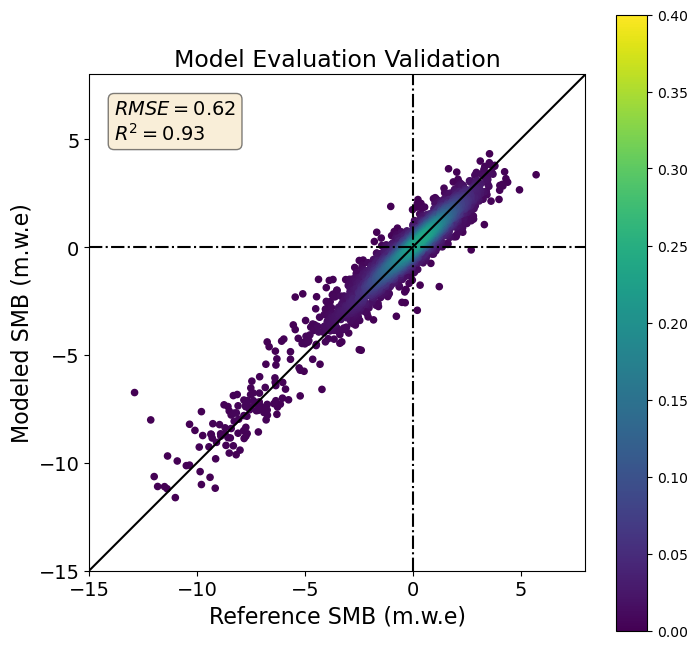

In [32]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [35]:
import joblib

# Save cv-object
joblib.dump(cv_grid, 'Models/cv_block_glacier_5fold_minimal_climate.pkl')
# joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_block_glacier_5fold_minimal_climate.pkl']

In [33]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X_s.columns)[ind]

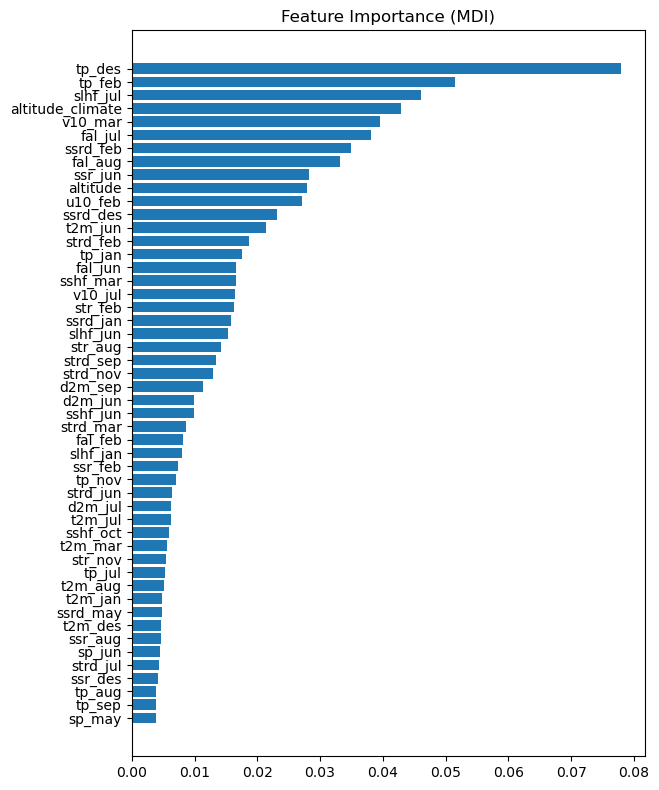

In [34]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Train model with max features including latitude and longitude


In [36]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [37]:
# Select columns to drop (lat and lon not dropped!)
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_des','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_des','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_des','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation] for y in x]

df_train_X_s = df_train.drop(drop_cols, axis=1)
df_train_y_s = df_train[['balance_netto']]


In [38]:
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get shuffled glacier ids
gp_s = np.array(df_train_s['BREID'].values)

In [39]:
# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split dataset into groups based on shuffled glacier ids.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [40]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -0.33536271001054996
Grid search best hyperparameters:  {'learning_rate': 0.25, 'max_depth': 3, 'n_estimators': 350}
Cross validation scores per fold:  [-0.36794293 -0.38691889 -0.29305868 -0.30210591 -0.32678713]
Mean cross validation score:  -0.33536271001054996
Standard deviation:  0.03657511954894253


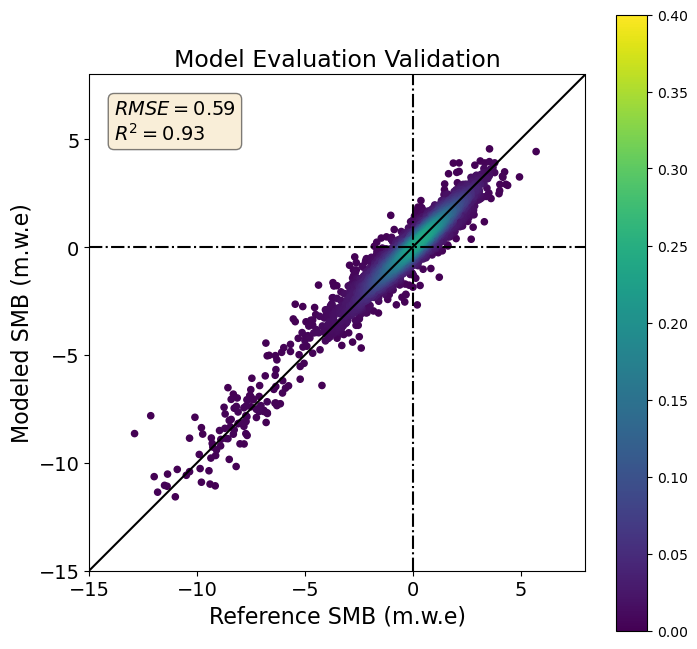

In [41]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [42]:
import joblib

# Save cv-object
joblib.dump(cv_grid, 'Models/cv_block_glacier_5fold_all_climate_latlon.pkl')
# joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_block_glacier_5fold_all_climate_latlon.pkl']

In [43]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X_s.columns)[ind]

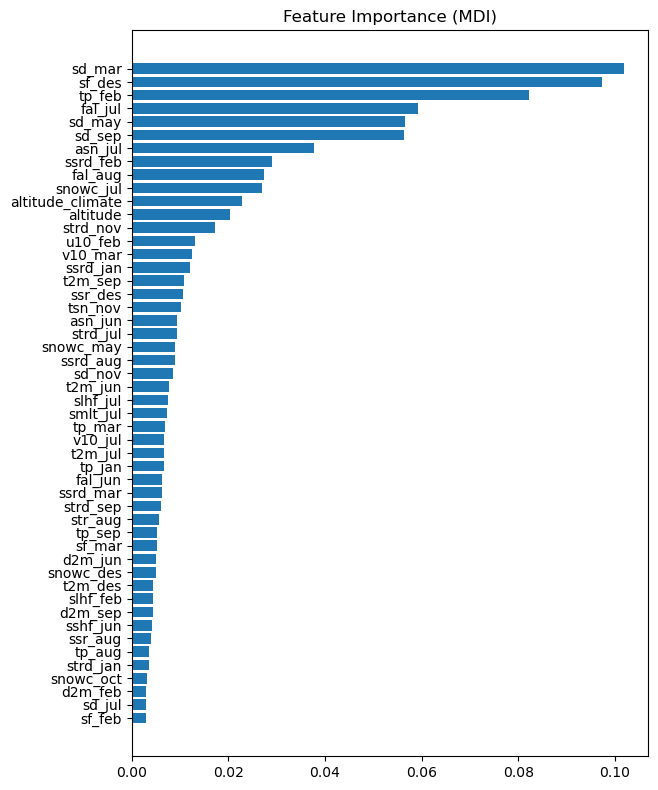

In [44]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Train model with minimual climate features, but including latitude and longitude

In [4]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [5]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_des','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_des','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_des','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_des','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_des','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_des','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_des','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_des','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_des','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo] for y in x]

df_train_X_s = df_train.drop(drop_cols, axis=1)
df_train_y_s = df_train[['balance_netto']]

In [6]:
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get shuffled glacier ids
gp_s = np.array(df_train_s['BREID'].values)

In [7]:
# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split dataset into groups based on shuffled glacier ids.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [8]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -0.33522889766632424
Grid search best hyperparameters:  {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 400}
Cross validation scores per fold:  [-0.36416549 -0.42934756 -0.24647252 -0.31689251 -0.31926641]
Mean cross validation score:  -0.33522889766632424
Standard deviation:  0.06027332181500537


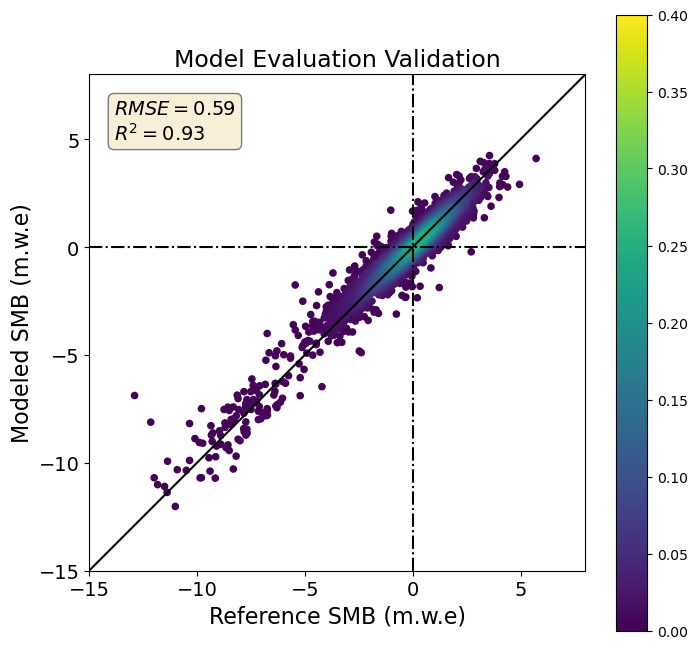

In [9]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [10]:
import joblib

# Save cv-object
joblib.dump(cv_grid, 'Models/cv_block_glacier_5fold_minimal_climate_latlon.pkl')
# joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_block_glacier_5fold_minimal_climate_latlon.pkl']

In [11]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X_s.columns)[ind]

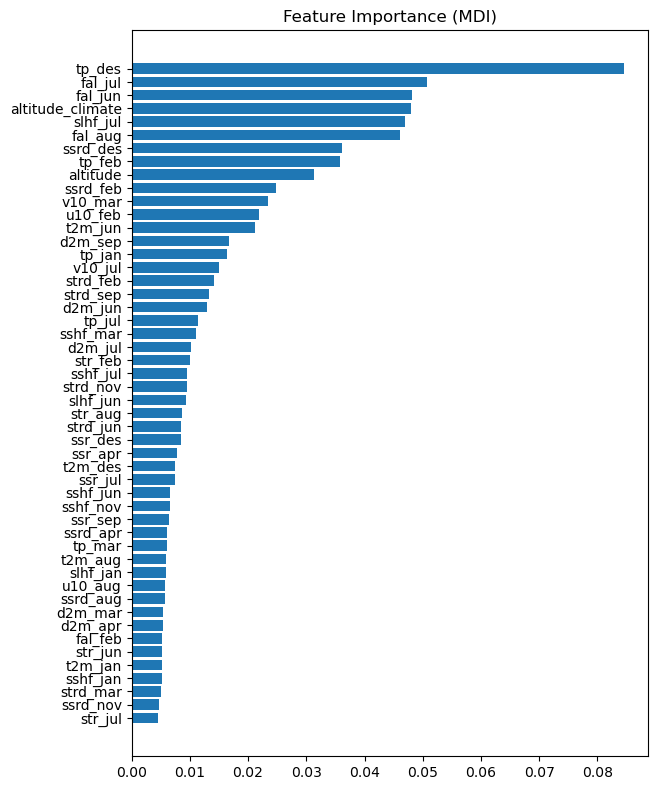

In [12]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()